# Sales Prediction
Brief notebook to explore, prepare, and model sales using supervised learning.


In [16]:
# Cell 2: imports and filepath
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt



## Load data
Load the CSV and inspect basic shape and columns.

In [17]:
# Cell 4: load and peek

DATA_PATH = "Advertising.csv"
df = pd.read_csv(DATA_PATH, index_col=0)

print("Shape after dropping first column:", df.shape)
display(df.head())
display(df.describe(include='all').T)


Shape after dropping first column: (200, 4)


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


## Quick EDA
Check missing values, dtypes, and target distribution.


Dtypes:
TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

Missing values:
TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

Target detected: 'Sales'


count    200.000000
mean      14.022500
std        5.217457
min        1.600000
25%       10.375000
50%       12.900000
75%       17.400000
max       27.000000
Name: Sales, dtype: float64

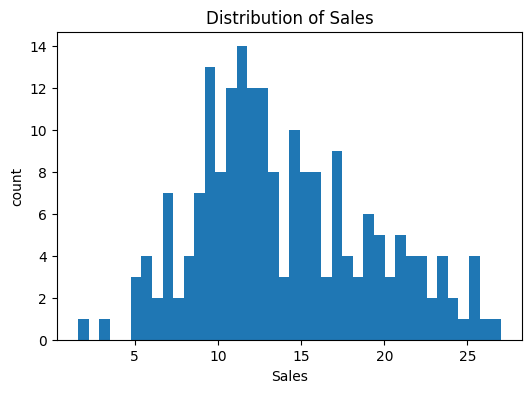

In [18]:
# Cell 6: EDA
print("Dtypes:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# If there is a numeric target column named 'Sales' (common), show distribution.
target_candidates = ["Sales", "sale", "Amount", "Revenue", "sales"]
target = None
for t in target_candidates:
    if t in df.columns:
        target = t
        break

if target:
    print(f"\nTarget detected: '{target}'")
    display(df[target].describe())
    plt.figure(figsize=(6,4))
    plt.hist(df[target].dropna(), bins=40)
    plt.title(f"Distribution of {target}")
    plt.xlabel(target)
    plt.ylabel("count")
    plt.show()
else:
    print("\nNo common target column detected. Please set the target variable name and rerun.")


## Data cleaning
Handle missing data and basic type fixes. Adjust as needed for your dataset.


In [19]:
# Cell 8: basic cleaning (non-destructive)
df_clean = df.copy()

# Example fixes (comment/uncomment per dataset):
# - strip column names
df_clean.columns = df_clean.columns.str.strip()

# - convert date-like columns if any (attempt)
for col in df_clean.select_dtypes(include=['object']).columns:
    try:
        dt = pd.to_datetime(df_clean[col], errors='coerce')
        # if many values convert, keep new column
        if dt.notna().sum() > len(df_clean) * 0.3:
            df_clean[col + "_dt"] = dt
    except Exception:
        pass

# Show updated summary
print("After basic cleaning:")
print(df_clean.info())


After basic cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB
None


## Feature selection & target
Choose the target and candidate features. Update `TARGET` if different.


In [21]:
# Cell 10: choose target and features (update TARGET if needed)
TARGET = target  # from earlier detector; if None set manually, e.g. TARGET = "Sales"
if TARGET is None:
    raise ValueError("No target detected. Set TARGET = 'YourTargetColumn' and rerun this cell.")

# Auto-select numeric and categorical features, excluding target
X = df_clean.drop(columns=[TARGET])
y = df_clean[TARGET]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))


Numeric features: 3
Categorical features: 0


## Preprocessing pipeline
Create a pipeline that imputes and scales numeric features and encodes categorical features.


In [28]:
# Cell 12: preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # updated
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder='drop')


## Train/test split and baseline
Split the data and fit a simple baseline model (Linear Regression).


In [29]:
# Cell 14: split and baseline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

print("Linear Regression performance:")
print(regression_report(y_test, y_pred_lr))


Linear Regression performance:
{'RMSE': np.float64(1.781599661533451), 'MAE': 1.4607567168117601, 'R2': 0.8994380241009119}


## Train stronger models
Train Random Forest and Gradient Boosting, compare performance.


In [30]:
# Cell 16: RandomForest and GradientBoosting pipelines
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("reg", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

gbr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("reg", GradientBoostingRegressor(n_estimators=200, random_state=42))
])

# Fit models
rf_pipeline.fit(X_train, y_train)
gbr_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_gbr = gbr_pipeline.predict(X_test)

print("Random Forest:", regression_report(y_test, y_pred_rf))
print("Gradient Boosting:", regression_report(y_test, y_pred_gbr))


Random Forest: {'RMSE': np.float64(0.7575226399257007), 'MAE': 0.6296250000000019, 'R2': 0.9818195432831535}
Gradient Boosting: {'RMSE': np.float64(0.726875613723803), 'MAE': 0.6142684383978981, 'R2': 0.9832608364557235}


## Hyperparameter tuning (example)
Grid search for Random Forest. This is a small grid — expand if needed.


In [31]:
# Cell 18: small grid search (can take time)
param_grid = {
    "reg__n_estimators": [100, 300],
    "reg__max_depth": [None, 10, 20]
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Tuned RF performance:", regression_report(y_test, y_pred_best))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'reg__max_depth': None, 'reg__n_estimators': 300}
Tuned RF performance: {'RMSE': np.float64(0.7406343902358283), 'MAE': 0.6140000000000011, 'R2': 0.9826211392674512}


## Evaluation plots
Residuals and true vs predicted to inspect model errors.


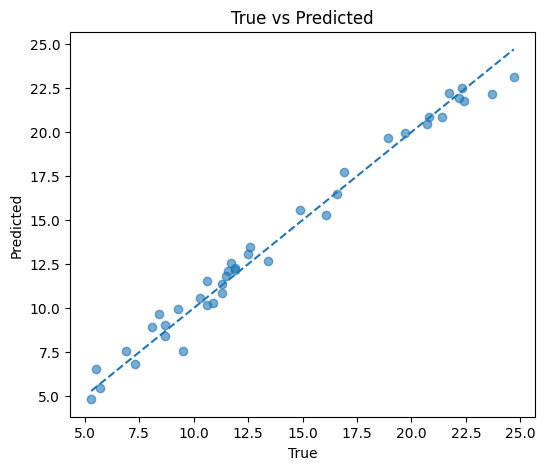

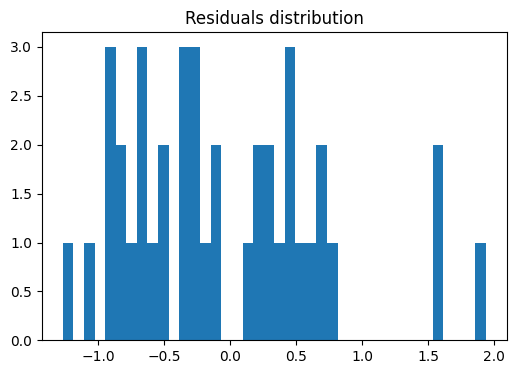

In [32]:
# Cell 20: residuals and true vs predicted for best model if available
model_to_plot = best_rf if 'best_rf' in globals() else rf_pipeline
y_pred = model_to_plot.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("True vs Predicted")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.title("Residuals distribution")
plt.show()


## Feature importance
Show feature importances from the Random Forest (after preprocessing).


TV           0.625447
Radio        0.361745
Newspaper    0.012808
dtype: float64

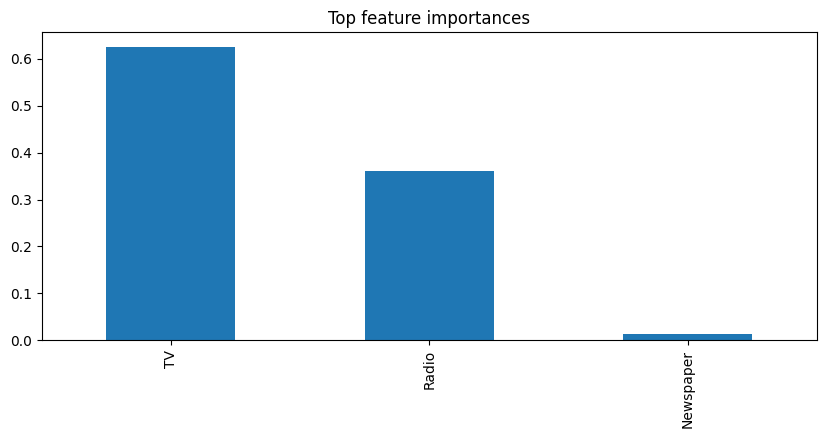

In [33]:
# Cell 22: feature importances (works when using onehot encoding)
# We need the transformed feature names
pre = model_to_plot.named_steps['preprocessor']
# numeric names
numeric_features = num_cols
# categorical: get categories from onehot encoder
cat_names = []
if cat_cols:
    ohe = pre.named_transformers_['cat'].named_steps['onehot']
    cat_features = pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
    cat_names = list(cat_features)

feature_names = list(numeric_features) + cat_names

# get underlying regressor feature importances
reg = model_to_plot.named_steps.get('reg') or model_to_plot.named_steps.get('regressor')
importances = reg.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
display(fi)
fi.plot(kind='bar', figsize=(10,4))
plt.title("Top feature importances")
plt.show()


## Save model
Save the final model with joblib for later use.


In [34]:
# Cell 24: save model
import joblib
final_model = model_to_plot
joblib.dump(final_model, "final_sales_model.joblib")
print("Saved final model to 'final_sales_model.joblib'")


Saved final model to 'final_sales_model.joblib'


## Conclusion & next steps
- Compare models and choose based on RMSE/MAE and business needs.  
- Next: tune more hyperparameters, add time-series features (if data is temporal), or try XGBoost/LightGBM.  
- If the dataset is small, prefer simpler models or cross-validation.
